In [1]:
%matplotlib widget

In [2]:
greyscale=['#000000','#000000','#0F0F0F','#1F1F1F','#2E2E2E','#3D3D3D','#4D4D4D','#5C5C5C','#6B6B6B','#7A7A7A','#8A8A8A','#999999','#A8A8A8','#B8B8B8','#C7C7C7','#D6D6D6','#E6E6E6','#F5F5F5']
colors_g=['#00009C','#0009AF','#002EB9','#0054BE','#0079C0','#009CC1','#00BDC2','#00C2A8','#00C18B','#02BF71','#01D723','#02E302','#03EE03','#25FA03','#5BFF04','#98FF05','#DEFF05']

In [3]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
seed=2024

### Define functions

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
def compute_pca(x,n_comp=50):
    model = PCA(n_components=n_comp).fit(x.T)
    C = model.components_
    pc_s = C @ x
    return model,pc_s

In [6]:
def plot_pc(pcomp,colors,t_epochs,area,figsize):
    fig,ax = plt.subplots(2,3,figsize=figsize)
    j_ax=0
    i_ax = 0
    for i in np.arange(0,4):
        for j in np.arange(0+i,4):
            if i==j:
                continue
            if j_ax>=3: 
                i_ax = 1 
                j_ax = 0
            for key in t_epochs.keys():
                ax[i_ax,j_ax].scatter(pcomp[i][t_epochs[key]],pcomp[j][t_epochs[key]],s=8,color=colors[key],label=key)

            ax[i_ax,j_ax].set(xlabel="PC "+str(i+1), ylabel="PC "+str(j+1))
            j_ax+=1
    fig.suptitle(area)
    ax[0,0].legend(fontsize=10,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='best')
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [7]:
def plot_pc_neu(pcomp,pcomp_neu,colors,colors_neu,t_epochs,area,figsize):
    fig,ax = plt.subplots(2,3,figsize=figsize)
    j_ax=0
    i_ax = 0
    for i in np.arange(0,4):
        for j in np.arange(0+i,4):
            if i==j:
                continue
            if j_ax>=3: 
                i_ax = 1 
                j_ax = 0
            for key in t_epochs.keys():
                ax[i_ax,j_ax].scatter(pcomp[i][t_epochs[key]],pcomp[j][t_epochs[key]],s=8,color=colors[key],label=key)
                ax[i_ax,j_ax].scatter(pcomp_neu[i][t_epochs[key]],pcomp_neu[j][t_epochs[key]],s=8,color=colors_neu[key],label=key)
            ax[i_ax,j_ax].set(xlabel="PC "+str(i+1), ylabel="PC "+str(j+1))
            j_ax+=1
    fig.suptitle(area)
    ax[0,0].legend(fontsize=10,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='best')
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [32]:
def plot_pc_3d(pcomp,colors,t_epochs,area,figsize=(5,5)):
    i=0
    fig,ax = plt.subplots(figsize=figsize,sharey=True,sharex=True, subplot_kw={'projection': '3d'})
    for key in t_epochs.keys():
        ax.plot(pcomp[i][t_epochs[key]],pcomp[i+1][t_epochs[key]],pcomp[i+2][t_epochs[key]],color=colors[key],label=key)
    fig.suptitle(area)
    ax.set(xlabel="PC "+str(i), ylabel="PC "+str(i+1), zlabel="PC "+str(i+2))
    ax.legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='best')
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [9]:
def plot_explained_var(model,figsize):
    fig,ax = plt.subplots(figsize=figsize)
    exp_var_pca = model.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    # Create the visualization plot
    ax.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    ax.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    ax.set(xlabel='Principal component index', ylabel='Explained variance ratio')
    ax.legend(loc='best')
    print("%d components to explain 80%% of the variance"%np.where(cum_sum_eigenvalues>0.8)[0][0])

### Read data

In [37]:
# Load data
time_before=500
start=-200
n_test=4
end_test = 200+n_test*450
end=450+200+end_test+200
# Define epochs
test1_st =200+450+400
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d = np.arange(200+450,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test4_st,end-start,2)

In [38]:
t_epochs = {'fixation':idx_f,'sample':idx_s,'delay':idx_d,'test1':idx_t1,'test2':idx_t2,'test3':idx_t3,'test4':idx_t4,'test off':idx_aftert}
colors = {'fixation':colors_g[0],'sample':colors_g[3],'delay':colors_g[6],'test1':colors_g[8],'test2':colors_g[10],'test3':colors_g[12],'test4':colors_g[13],'test off':colors_g[15]}
colors_neu = {'fixation':greyscale[0],'sample':greyscale[3],'delay':greyscale[6],'test1':greyscale[8],'test2':greyscale[10],'test3':greyscale[12],'test4':greyscale[13],'test off':greyscale[15]}

In [43]:
n_comp=50
pc_areas = {}
for area in ['lip']:
    neurons_fr_read=from_python_hdf5(load_path='C:/Users/camil/Downloads/pca/'+area+'_win50_test'+str(n_test)+'_pca.h5')
    neurons_fr = []
    for asc in neurons_fr_read:
        fr = asc["fr"]
        if fr is not None:
            fr_concat = np.concatenate(fr,axis=0)
            neurons_fr.append(fr_concat)
    neurons_fr = np.array(neurons_fr)
    model,pc_s = compute_pca(neurons_fr,n_comp=n_comp)
    pc_areas[area] = {'model':model,'pc':pc_s}


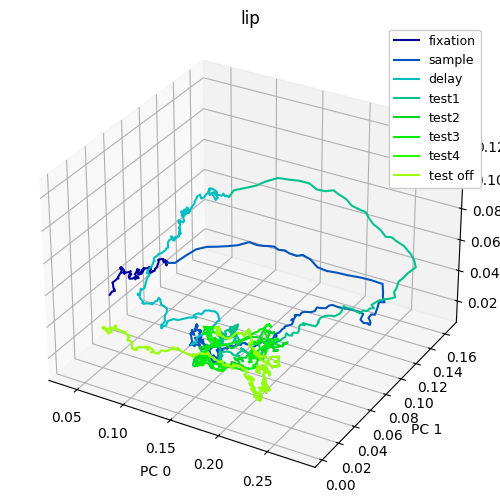

In [44]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    plot_pc_3d(mean_pc_s,colors,t_epochs,area,figsize=(5,5))


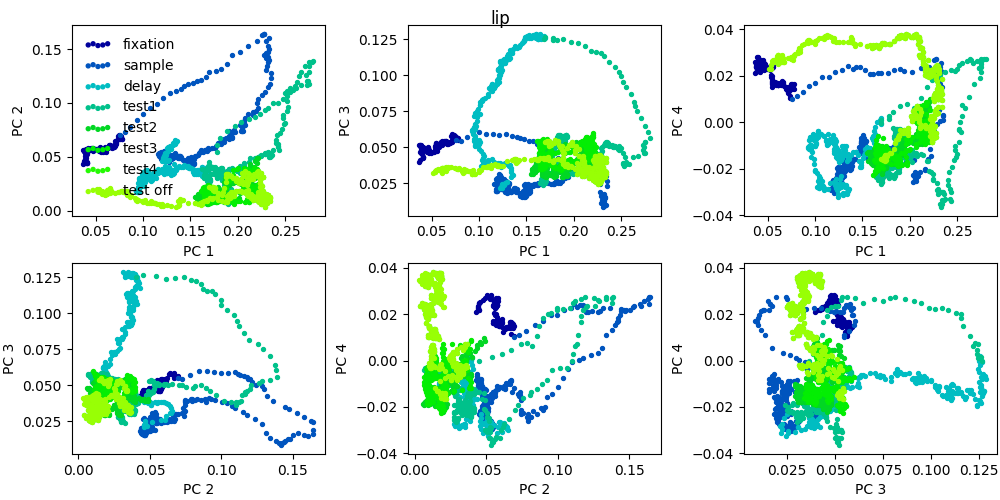

In [45]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    plot_pc(mean_pc_s,colors,t_epochs,area,figsize=(10,5))

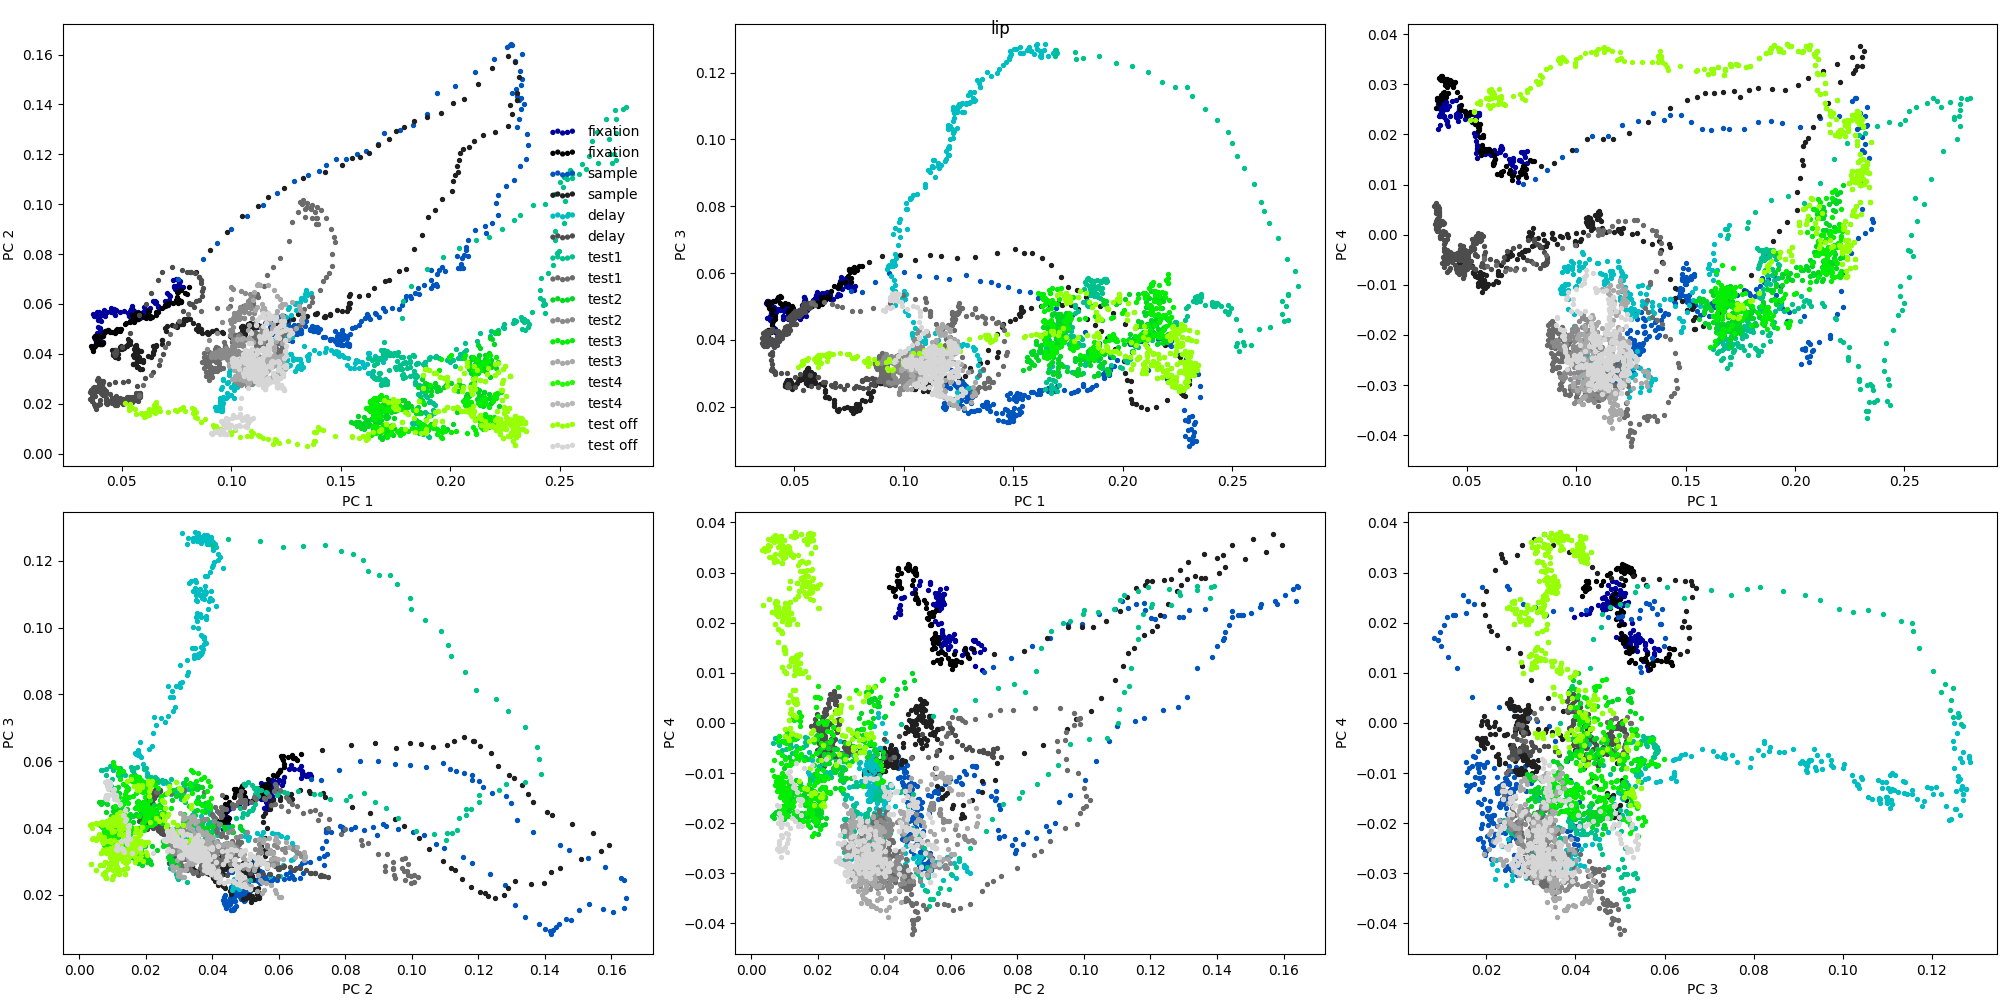

In [46]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors,colors_neu,t_epochs,area,figsize=(20,10))

9 components to explain 80% of the variance


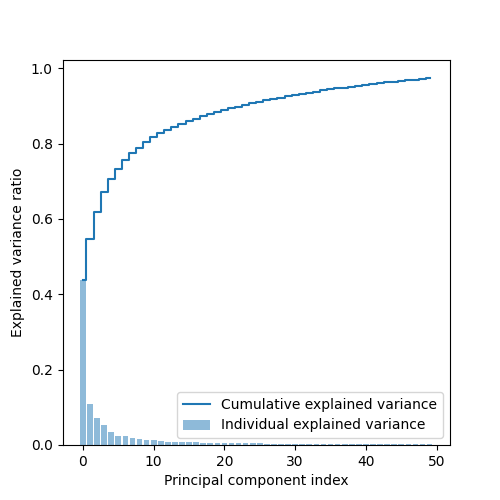

In [47]:
plot_explained_var(model,figsize=(5,5))